# SCOPED Container for ML catalog construction
This notebook is part of the SCOPED container for machine learning based earthquake catalog construction. The SCOPED Container page is at https://github.com/SeisSCOPED/ml_catalog

Follow the instructions to pull and run the tutorial container: 

## To run it on your local machine:
Install docker from https://docs.docker.com/get-docker/

For Mac: ```https://docs.docker.com/desktop/install/mac-install/```

For Linux: ```https://docs.docker.com/desktop/install/linux-install/```

For Windows: ```https://docs.docker.com/desktop/install/windows-install/```

## To run it on AWS cloud (SCOPED workshop users):
Follow instructions on https://seisscoped.org/HPS-book/chapters/cloud/AWS_101.html to log in to AWS and launching your instance. 

When launching your instance (at Step 2), in the **Application and OS Images (Amazon Machine Image)** block, choose **Architecture* as **64-bit (Arm)**. 

Use 'option 1' to install docker on your instance. And then pull container image with the command lines below.

## Pulling container image
Use the following commands to pull the container from the GitHub Container Registry (GHCR):
```
docker pull ghcr.io/seisscoped/ml_catalog:latest

docker run -p 8888:8888 ghcr.io/seisscoped/ml_catalog:latest
```
##### For **SCOPED workshop users**, use:
```
sudo docker pull ghcr.io/seisscoped/ml_catalog:latest

sudo docker run -p 8888:8888 ghcr.io/seisscoped/ml_catalog:latest
```


### Run tutorial Jupyter Notebook

The container will start JupyterLab with a link to open it in a web browser, something like:
```
To access the notebook, open this file in a browser:
        file:///root/.local/share/jupyter/runtime/nbserver-1-open.html
Or copy and paste one of these URLs:
        http://35e1877ea874:8888/?token=1cfd3a35f9d58cfd52807494ab36dd7166140bb856dbfbb7
or http://127.0.0.1:8888/?token=1cfd3a35f9d58cfd52807494ab36dd7166140bb856dbfbb7

```
Copy and paste one of the URLs to open it in a browser. Then run the tutorial notebook ```MLworkflow.ipynb```

##### For **SCOPED workshop users**,

Find the **Public IPv4 DNS** of your AWS instance, replace the IP address in the link with this Public IPv4 DNS and open it in your web browser. 

This will open a JupyterLab of the tutorial. Then run the notebook "MLworkflow.ipynb" for machine learning catalog construction workflow.



# SCOPED tutorial for ML catalog construction

This is a Jupyther Notebook of SCOPED tutorial for machine learning catalog construction workflow.

The notebook includes code and examples to download continuous data, detect and pick phases with PhaseNet, assoicate the phases with GaMMA, locate them with HypoInverse, and relocate the events with HypoDD.

### Links to the packages/functions:

- Data downloaded with ObsPy Mass Downloader fuction (https://docs.obspy.org/packages/obspy.clients.fdsn.html)

- PhaseNet for phase picking (https://github.com/AI4EPS/PhaseNet)

- GaMMA for picks association (https://github.com/AI4EPS/GaMMA)

- HypoInverse for single event location (https://www.usgs.gov/software/hypoinverse-earthquake-location)

- HypoDD for double difference relocation (https://github.com/fwaldhauser/HypoDD)

### References:

- Moritz Beyreuther, Robert Barsch, Lion Krischer, Tobias Megies, Yannik Behr and Joachim Wassermann (2010), ObsPy: A Python Toolbox for Seismology, SRL, 81(3), 530-533, doi:10.1785/gssrl.81.3.530.

- Zhu, Weiqiang, and Gregory C. Beroza. "PhaseNet: A Deep-Neural-Network-Based Seismic Arrival Time Picking Method." arXiv preprint arXiv:1803.03211 (2018).

- Zhu, Weiqiang et al. "Earthquake Phase Association using a Bayesian Gaussian Mixture Model." (2021)

- Klein, Fred W. User's guide to HYPOINVERSE-2000, a Fortran program to solve for earthquake locations and magnitudes. No. 2002-171. US Geological Survey, 2002.

- Waldhauser, Felix, and William L. Ellsworth, A double-difference
earthquake location algorithm: Method and application to the northern
Hayward fault, California, Bull. Seism. Soc. Am. 90, 1353-1368, 2000.

### ML catalog tutorial: Amatrice, Italy October 2016

Tutorial Steps:
1. Download data
2. Phasenet detection & phase picking
3. GaMMA Association
4. HypoInverse location
5. HypoDD double difference relocation 

You might need to change <mark>parameters in highlighted lines</mark> base on your dataset.

### Download data
Download continous data from IRIS and INGV. Here we download one-day data for test run. 

Data downloaded with ObsPy Mass Downloader fuction.
See more information at https://docs.obspy.org/packages/obspy.clients.fdsn.html

<mark>Data download parameters: </mark> 

- Define study region: latitude, longitude, maxradius
- Time range: starttime, endtime
- Station information: network, channel_priorities

In [1]:
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.clients.fdsn.mass_downloader import RectangularDomain, \
    Restrictions, MassDownloader, CircularDomain
from pathlib import Path

domain = CircularDomain(latitude=42.75, longitude=13.25,
                                minradius=0.0, maxradius=1)

wfBaseDir='./waveforms'
Path(wfBaseDir).mkdir(parents=True, exist_ok=True)

restrictions = Restrictions(
    starttime = obspy.UTCDateTime(2016, 10,18,0,0,0),
    endtime   = obspy.UTCDateTime(2016, 10,18,0,10,0),
    chunklength_in_sec=86400,
    network="YR,IV",
    channel_priorities=["[HE][HN]?"],
    reject_channels_with_gaps=False,
    minimum_length=0.0,
    minimum_interstation_distance_in_m=100.0)

mdl = MassDownloader(providers=["IRIS", "INGV"])
mdl.download(domain, restrictions,
             mseed_storage=wfBaseDir+"/{network}/{station}/"
                         "{channel}.{location}.{starttime}.{endtime}.mseed",
             stationxml_storage="stations")

[2024-04-28 20:56:57,038] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS, INGV.
[2024-04-28 20:56:57,550] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 2 client(s): IRIS, INGV.
[2024-04-28 20:56:57,553] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2024-04-28 20:56:57,555] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Requesting reliable availability.
[2024-04-28 20:56:58,244] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Successfully requested availability (0.69 seconds)
[2024-04-28 20:56:58,247] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Found 24 stations (72 channels).
[2024-04-28 20:56:58,253] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Will attempt to download data from 24 stations.
[2024-04-28 20:56:58,256] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Status for 72 time intervals/channels before downl

{'IRIS': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0xffff8af65990>,
 'INGV': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0xffff35c6f7c0>}

### Prepare PhaseNet input files and running PhaseNet for phase picking
PhaseNet model from https://github.com/AI4EPS/PhaseNet

##### Reference:
Zhu, Weiqiang, and Gregory C. Beroza. "PhaseNet: A Deep-Neural-Network-Based Seismic Arrival Time Picking Method." arXiv preprint arXiv:1803.03211 (2018).

##### Write input waveform file path from the downloaded miniseed waveforms:
write input files required by PhaseNet: use the miniseed data we just downloaded

In [2]:
import glob
import numpy as np

PhasenetResultDir='./results_phasenet'
Path(PhasenetResultDir).mkdir(parents=True, exist_ok=True)
mseed_path=wfBaseDir+'/*/*/*.mseed'
filenames = glob.glob(mseed_path)

filenames=['./'+file.split('/')[2]+'/'+file.split('/')[3]+'/*.*.'+(file.split('/')[-1]).split('.')[2]+'.*.mseed' for file in filenames]
filenames=np.unique(filenames)
print('number of stations',len(filenames))
filenames=np.insert(filenames, 0, 'fname')

np.savetxt(PhasenetResultDir+'/mseed.csv', filenames, fmt='%s')


number of stations 92


##### Write station file from the .xml files:
generate input station file with the .xml files we just downloaded

In [3]:
from obspy import read_inventory
from collections import defaultdict
import pandas as pd
inv = read_inventory("./stations/*.xml")

station_locs = defaultdict(dict)
stations=inv
for network in stations:
    for station in network:
        for chn in station:
            sid = f"{network.code}.{station.code}.{chn.location_code}.{chn.code[:-1]}"
            if sid in station_locs:
                station_locs[sid]["component"] += f",{chn.code[-1]}"
                station_locs[sid]["response"] += f",{chn.response.instrument_sensitivity.value:.2f}"
            else:
                component = f"{chn.code[-1]}"
                response = f"{chn.response.instrument_sensitivity.value:.2f}"
                dtype = chn.response.instrument_sensitivity.input_units.lower()
                tmp_dict = {}
                tmp_dict["longitude"], tmp_dict["latitude"], tmp_dict["elevation(m)"] = (
                    chn.longitude,
                    chn.latitude,
                    chn.elevation,
                )
                tmp_dict["component"], tmp_dict["response"], tmp_dict["unit"] = component, response, dtype
                station_locs[sid] = tmp_dict
            if station_locs[sid]["component"]=='Z':
                station_locs[sid]["response"]= f"0,0,"+station_locs[sid]["response"]
            elif station_locs[sid]["component"]=='N,Z':
                station_locs[sid]["response"]= f"0,"+station_locs[sid]["response"]
station_locs = pd.DataFrame.from_dict(station_locs, orient='index')
station_locs["id"] = station_locs.index
station_locs = station_locs.rename_axis('station').reset_index()
station_locs.to_csv("./stations.csv",sep='\t')
station_locs

,station,longitude,latitude,elevation(m),component,response,unit,id
0,IV.AOI..HH,13.60200,43.550170,530.0,"E,N,Z","1179650000.00,1179650000.00,1179650000.00",m/s,IV.AOI..HH
1,IV.ARRO..EH,12.76567,42.579170,253.0,"E,N,Z","503316000.00,503316000.00,503316000.00",m/s,IV.ARRO..EH
2,IV.ARVD..HH,12.94153,43.498070,461.0,"E,N,Z","1179650000.00,1179650000.00,1179650000.00",m/s,IV.ARVD..HH
3,IV.ASSB..HH,12.65870,43.042600,734.0,"E,N,Z","8823530000.00,8823530000.00,8823530000.00",m/s,IV.ASSB..HH
4,IV.ATBU..EH,12.54828,43.475710,1000.0,"E,N,Z","503316000.00,503316000.00,503316000.00",m/s,IV.ATBU..EH
...,...,...,...,...,...,...,...,...
110,YR.ED21..HH,13.27227,43.030071,720.0,"E,N,Z","2463140000.00,2456910000.00,2455960000.00",m/s,YR.ED21..HH
111,YR.ED22..HH,13.32520,43.006748,620.0,"E,N,Z","2417850000.00,2419350000.00,2423940000.00",m/s,YR.ED22..HH
112,YR.ED23..HH,13.28710,42.743191,1045.0,"E,N,Z","2318760000.00,2340510000.00,2317430000.00",m/s,YR.ED23..HH
113,YR.ED24..HH,13.19232,42.655640,1104.0,"E,N,Z","2488010000.00,2543750000.00,2506750000.00",m/s,YR.ED24..HH


### Run PhaseNet 
Phase picking on continous data. Output phase picks for given station and waveform files.

In [4]:
!python ./phasenet/predict.py --model=./phasenet/model/190703-214543 --data_list=./results_phasenet/mseed.csv --data_dir=./waveforms --format=mseed_array --amplitude --result_dir=./results_phasenet/result/ --stations=./stations.csv


     Unnamed: 0      station  ...  unit           id
0             0   IV.AOI..HH  ...   m/s   IV.AOI..HH
1             1  IV.ARRO..EH  ...   m/s  IV.ARRO..EH
2             2  IV.ARVD..HH  ...   m/s  IV.ARVD..HH
3             3  IV.ASSB..HH  ...   m/s  IV.ASSB..HH
4             4  IV.ATBU..EH  ...   m/s  IV.ATBU..EH
..          ...          ...  ...   ...          ...
110         110  YR.ED21..HH  ...   m/s  YR.ED21..HH
111         111  YR.ED22..HH  ...   m/s  YR.ED22..HH
112         112  YR.ED23..HH  ...   m/s  YR.ED23..HH
113         113  YR.ED24..HH  ...   m/s  YR.ED24..HH
114         114  YR.ED25..HH  ...   m/s  YR.ED25..HH

[115 rows x 9 columns]
2024-04-28 20:57:08,118 Pred log: ./results_phasenet/result/
2024-04-28 20:57:08,118 Dataset size: 92
2024-04-28 20:57:08,171 Model: depths 5, filters 8, filter size 7x1, pool size: 4x1, dilation rate: 1x1
/app/phasenet/model.py:158: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.kera

### Run GaMMA 
Associating PhaseNet picks into events with GaMMA (https://github.com/AI4EPS/GaMMA)

##### Reference:
Zhu, Weiqiang et al. "Earthquake Phase Association using a Bayesian Gaussian Mixture Model." (2021)

##### Set GaMMA parameters:
<mark>Parameters you might want to change based on your dataset: </mark> 

- Define study region: center=(latitude, longitude), horizontal_degree, vertical_degree, z(km)
- Time range: starttime, endtime
- Station information: network_list, channel_list
- Association parameters: 
    - dbscan_eps (for sparse network use a larger number) 
    - min_picks_per_eq (minimum number of associated picks per event)
    - max_sigma11 (a larger value allows larger pick uncertainty)

In [5]:
GMMAResultDir='./GMMA'
Path(GMMAResultDir).mkdir(parents=True, exist_ok=True)

catalog_csv = GMMAResultDir+"/catalog_gamma.csv"
picks_csv = GMMAResultDir+"/picks_gamma.csv"


region_name = "Italy"
center = (13.2, 42.7)
horizontal_degree = 0.85
vertical_degree = 0.85
starttime = obspy.UTCDateTime("2016-10-18T00")
endtime =   obspy.UTCDateTime("2016-10-19T00")
network_list = ["IV","YR"]
channel_list = "HH*,EH*,HN*,EN*"

config = {}
config["region"] = region_name
config["center"] = center
config["xlim_degree"] = [center[0] - horizontal_degree / 2, center[0] + horizontal_degree / 2]
config["ylim_degree"] = [center[1] - vertical_degree / 2, center[1] + vertical_degree / 2]
config["starttime"] = starttime.datetime.isoformat()
config["endtime"] = endtime.datetime.isoformat()
config["networks"] = network_list
config["channels"] = channel_list
config["degree2km"] = 111
config["degree2km_x"] = 82
config['vel']= {"p":6.2, "s":3.3}


config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["use_dbscan"] = True
config["use_amplitude"] = True
config["x(km)"] = (np.array(config["xlim_degree"])-np.array(config["center"][0]))*config["degree2km_x"]
config["y(km)"] = (np.array(config["ylim_degree"])-np.array(config["center"][1]))*config["degree2km"]
config["z(km)"] = (0, 20)

# DBSCAN
config["bfgs_bounds"] = ((config["x(km)"][0]-1, config["x(km)"][1]+1), #x
                        (config["y(km)"][0]-1, config["y(km)"][1]+1), #y
                        (0, config["z(km)"][1]+1), #x
                        (None, None)) #t
config["dbscan_eps"] = 6
config["dbscan_min_samples"] = min(len(stations), 3)
config["min_picks_per_eq"] = min(len(stations)//2+1, 10)

config["method"] = "BGMM"
if config["method"] == "BGMM":
    config["oversample_factor"] = 4
if config["method"] == "GMM":
    config["oversample_factor"] = 1

config["max_sigma11"] = 2.0
config["max_sigma22"] = 1.0
config["max_sigma12"] = 1.0

for k, v in config.items():
    print(f"{k}: {v}")

region: Italy
center: (13.2, 42.7)
xlim_degree: [12.774999999999999, 13.625]
ylim_degree: [42.275000000000006, 43.125]
starttime: 2016-10-18T00:00:00
endtime: 2016-10-19T00:00:00
networks: ['IV', 'YR']
channels: HH*,EH*,HN*,EN*
degree2km: 111
degree2km_x: 82
vel: {'p': 6.2, 's': 3.3}
dims: ['x(km)', 'y(km)', 'z(km)']
use_dbscan: True
use_amplitude: True
x(km): [-34.85  34.85]
y(km): [-47.175  47.175]
z(km): (0, 20)
bfgs_bounds: ((-35.85000000000006, 35.85000000000006), (-48.174999999999685, 48.174999999999685), (0, 21), (None, None))
dbscan_eps: 6
dbscan_min_samples: 3
min_picks_per_eq: 10
method: BGMM
oversample_factor: 4
max_sigma11: 2.0
max_sigma22: 1.0
max_sigma12: 1.0


##### Write station file for GaMMA:
Read station file and write in GaMMA input format.

In [6]:
station_path='./stations.csv'
stations = pd.read_csv(station_path, delimiter="\t", index_col=0)

stations["x(km)"] = stations["longitude"].apply(lambda x: (x - config["center"][0])*config["degree2km_x"])
stations["y(km)"] = stations["latitude"].apply(lambda x: (x - config["center"][1])*config["degree2km"])
stations["z(km)"] = stations["elevation(m)"].apply(lambda x: -x/1e3)
stations["id"] = stations["id"].apply(lambda x: x.split('.')[1])
stations=stations.drop_duplicates(subset=['id'], keep='first')
stations['elevation(m)']=stations['elevation(m)']-np.min(stations['elevation(m)'])
stations['z(km)']=stations['z(km)']-np.min(stations['z(km)'])

stations

,station,longitude,latitude,elevation(m),component,response,unit,id,x(km),y(km),z(km)
0,IV.AOI..HH,13.60200,43.550170,528.0,"E,N,Z","1179650000.00,1179650000.00,1179650000.00",m/s,AOI,32.96400,94.368870,0.840
1,IV.ARRO..EH,12.76567,42.579170,251.0,"E,N,Z","503316000.00,503316000.00,503316000.00",m/s,ARRO,-35.61506,-13.412130,1.117
2,IV.ARVD..HH,12.94153,43.498070,459.0,"E,N,Z","1179650000.00,1179650000.00,1179650000.00",m/s,ARVD,-21.19454,88.585770,0.909
3,IV.ASSB..HH,12.65870,43.042600,732.0,"E,N,Z","8823530000.00,8823530000.00,8823530000.00",m/s,ASSB,-44.38660,38.028600,0.636
4,IV.ATBU..EH,12.54828,43.475710,998.0,"E,N,Z","503316000.00,503316000.00,503316000.00",m/s,ATBU,-53.44104,86.103810,0.370
...,...,...,...,...,...,...,...,...,...,...,...
110,YR.ED21..HH,13.27227,43.030071,718.0,"E,N,Z","2463140000.00,2456910000.00,2455960000.00",m/s,ED21,5.92614,36.637881,0.650
111,YR.ED22..HH,13.32520,43.006748,618.0,"E,N,Z","2417850000.00,2419350000.00,2423940000.00",m/s,ED22,10.26640,34.049028,0.750
112,YR.ED23..HH,13.28710,42.743191,1043.0,"E,N,Z","2318760000.00,2340510000.00,2317430000.00",m/s,ED23,7.14220,4.794201,0.325
113,YR.ED24..HH,13.19232,42.655640,1102.0,"E,N,Z","2488010000.00,2543750000.00,2506750000.00",m/s,ED24,-0.62976,-4.923960,0.266


##### Load pick file from PhaseNet output:
Read picks from PhaseNet output and remove duplicated picks (<0.05s).

In [7]:
picks_path='./results_phasenet/result/picks.json'
picks = pd.read_json(picks_path)

picks["time_idx"] = picks["timestamp"].apply(lambda x: x.strftime("%Y-%m-%dT%H")) ## process by hours
picks["id"] = picks["id"].apply(lambda x: x.split('.')[1])
picks=picks.sort_values(by=['id','type', 'timestamp'])

idx_keep=np.zeros(len(picks))
for i in range(0,len(picks)):
    for j in range(-min(2,i),min(2,len(picks)-i-1)):
        if abs((picks['timestamp'].iloc[i+j]-picks['timestamp'].iloc[i]).total_seconds())<=0.05 and picks['prob'].iloc[i+j]>picks['prob'].iloc[i] and picks['id'].iloc[i+j]==picks['id'].iloc[i] and picks['type'].iloc[i+j]==picks['type'].iloc[i]:
            idx_keep[i]=1
picks=picks[idx_keep==0]
picks


,id,timestamp,prob,amp,type,time_idx
0,ARRO,2016-10-17 23:59:57.910,0.701165,1.281848e-07,p,2016-10-17T23
1,ARRO,2016-10-18 00:00:11.280,0.662540,1.469117e-07,p,2016-10-18T00
6,ARVD,2016-10-18 00:03:02.790,0.379346,5.928066e-08,p,2016-10-18T00
3,ARVD,2016-10-18 00:03:43.020,0.925389,2.205629e-07,p,2016-10-18T00
4,ARVD,2016-10-18 00:03:13.600,0.736935,1.512733e-07,s,2016-10-18T00
...,...,...,...,...,...,...
893,VCEL,2016-10-18 00:03:30.540,0.348443,9.864515e-08,s,2016-10-18T00
894,VCEL,2016-10-18 00:03:51.140,0.829574,5.129172e-07,s,2016-10-18T00
887,VCEL,2016-10-18 00:04:26.380,0.317240,6.093083e-08,s,2016-10-18T00
888,VCEL,2016-10-18 00:09:40.760,0.345931,8.002770e-08,s,2016-10-18T00


##### Run GaMMA association:
Associate the picks into events and write results (a catalog with associated picks).

In [8]:
from gamma import BayesianGaussianMixture, GaussianMixture
from gamma.utils import convert_picks_csv, association, from_seconds
from tqdm import tqdm

pbar = tqdm(sorted(list(set(picks["time_idx"]))))
event_idx0 = 0 ## current earthquake index
assignments = []
if (len(picks) > 0) and (len(picks) < 5000):
    catalogs, assignments = association(picks, stations, config, event_idx0, config["method"], pbar=pbar)
    event_idx0 += len(catalogs)
else:
    catalogs = []
    for i, hour in enumerate(pbar):
        picks_ = picks[picks["time_idx"] == hour]
        if len(picks_) == 0:
            continue
        catalog, assign = association(picks_, stations, config, event_idx0, config["method"], pbar=pbar)
        event_idx0 += len(catalog)
        catalogs.extend(catalog)
        assignments.extend(assign)

## create catalog
catalogs = pd.DataFrame(catalogs)
catalogs["longitude"] = catalogs["x(km)"].apply(lambda x: x/config["degree2km_x"] + config["center"][0])
catalogs["latitude"] = catalogs["y(km)"].apply(lambda x: x/config["degree2km"] + config["center"][1])
catalogs["depth_km"] = catalogs["z(km)"]
with open(catalog_csv, 'w') as fp:
    catalogs.to_csv(fp, sep="\t", index=False,
                    float_format="%.3f",
                    date_format='%Y-%m-%dT%H:%M:%S.%f',
                    columns=["time", "magnitude", "longitude", "latitude", "depth_km", "sigma_time", "sigma_amp", "cov_time_amp", "event_index", "gamma_score"])
catalogs = catalogs[['time', 'magnitude', 'longitude', 'latitude', 'depth_km', 'sigma_time', 'sigma_amp', 'gamma_score']]

## add assignment to picks
assignments = pd.DataFrame(assignments, columns=["pick_idx", "event_index", "gamma_score"])
picks = picks.join(assignments.set_index("pick_idx")).fillna(-1).astype({'event_index': int})
with open(picks_csv, 'w') as fp:
    picks.to_csv(fp, sep="\t", index=False,
                    date_format='%Y-%m-%dT%H:%M:%S.%f',
                    columns=["id", "timestamp", "type", "prob", "amp", "event_index", "gamma_score"])

  0%|          | 0/2 [00:00<?, ?it/s]

Associating 36 clusters with 7 CPUs
....................................

### Run HypoInverse
Convert station file, phase file, and run single event location with HypoInverse (https://www.usgs.gov/software/hypoinverse-earthquake-location)

##### Reference:
Klein, Fred W. User's guide to HYPOINVERSE-2000, a Fortran program to solve for earthquake locations and magnitudes. No. 2002-171. US Geological Survey, 2002.

##### Convert station file format

In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm

stations = pd.read_csv("./stations.csv", sep="\t")
converted_hypoinverse = []
converted_hypoDD = {}

for i in tqdm(range(len(stations))):

    network_code, station_code, comp_code, channel_code = stations.iloc[i]['station'].split('.')
    station_weight = " "
    lat_degree = int(stations.iloc[i]['latitude'])
    lat_minute = (stations.iloc[i]['latitude'] - lat_degree) * 60
    north = "N" if lat_degree >= 0 else "S"
    lng_degree = int(stations.iloc[i]['longitude'])
    lng_minute = (stations.iloc[i]['longitude'] - lng_degree) * 60
    west = "W" if lng_degree <= 0 else "E"
    elevation = stations.iloc[i]['elevation(m)']
    line_hypoinverse = f"{station_code:<5} {network_code:<2} {comp_code[:-1]:<1}{channel_code:<3} {station_weight}{abs(lat_degree):2.0f} {abs(lat_minute):7.4f}{north}{abs(lng_degree):3.0f} {abs(lng_minute):7.4f}{west}{elevation:4.0f}\n"
    converted_hypoinverse.append(line_hypoinverse)
    converted_hypoDD[f"{station_code}"] = f"{network_code:<2}{station_code:<5} {stations.iloc[i]['latitude']:.3f} {stations.iloc[i]['longitude']:.3f} {elevation:4.0f}\n"

out_file = 'stations_hypoinverse.dat'
with open(out_file, 'w') as f:
    f.writelines(converted_hypoinverse)

out_file = 'stations_hypoDD.dat'
with open(out_file, 'w') as f:
    for k, v in converted_hypoDD.items():
        f.write(v)



100%|██████████| 115/115 [00:00<00:00, 4344.35it/s]


##### Write phase file in HypoInverse format:
Read GaMMA associated events and write in HypoInverse phase input format 

In [10]:
from datetime import datetime

stations = pd.read_csv("./stations.csv", sep="\t")
stations['net']=stations['station'].apply(lambda x: x.split('.')[0])
stations['sta']=stations['station'].apply(lambda x: x.split('.')[1])
stations['cha']=stations['station'].apply(lambda x: x.split('.')[3])

picks = pd.read_csv(GMMAResultDir+"/picks_gamma.csv", sep="\t")
events = pd.read_csv(GMMAResultDir+"/catalog_gamma.csv", sep="\t")

events["match_id"] = events["event_index"]
picks["match_id"] = picks["event_index"]
events.sort_values(by="time", inplace=True, ignore_index=True)

out_file = open("./hypoInv/hypoInput.arc", "w")


picks_by_event = picks.groupby("match_id").groups
for i in tqdm(range(len(events))):

    event = events.iloc[i]
    event_time = datetime.strptime(event["time"], "%Y-%m-%dT%H:%M:%S.%f").strftime("%Y%m%d%H%M%S%f")[:-4]
    lat_degree = int(event["latitude"])
    lat_minute = (event["latitude"] - lat_degree) * 60 * 100
    south = "S" if lat_degree <= 0 else " "
    lng_degree = int(event["longitude"])
    lng_minute = (event["longitude"] - lng_degree) * 60 * 100
    east = "E" if lng_degree >= 0 else " "
    depth = event["depth_km"]
    if np.sum(picks[picks["event_index"]==events.iloc[i]['match_id']]['type']=='p')==0:
        continue
    event_line = f"{event_time}{abs(lat_degree):2d}{south}{abs(lat_minute):4.0f}{abs(lng_degree):3d}{east}{abs(lng_minute):4.0f}{depth:5.0f}"
    out_file.write(event_line + "\n")

    picks_idx = picks_by_event[event["match_id"]]
    for j in picks_idx:
        pick = picks.iloc[j]
        station_code = pick['id']
        network_code = stations['net'][stations['sta'] == pick['id']].iloc[0]
        comp_code = ''
        channel_code = stations['cha'][stations['sta'] == pick['id']].iloc[0]
        phase_type = pick['type']
        phase_weight = min(max(int((1 - pick['prob']) / (1 - 0.3) * 4) - 1, 0), 3)
        pick_time = datetime.strptime(pick["timestamp"], "%Y-%m-%dT%H:%M:%S.%f")
        phase_time_minute = pick_time.strftime("%Y%m%d%H%M")
        phase_time_second = pick_time.strftime("%S%f")[:-4]
        tmp_line = f"{station_code:<5}{network_code:<2} {comp_code:<1}{channel_code:<3}"
        if phase_type.upper() == 'P':
            pick_line = f"{tmp_line:<13} P {phase_weight:<1d}{phase_time_minute} {phase_time_second}"
        elif phase_type.upper() == 'S':
            pick_line = f"{tmp_line:<13}   4{phase_time_minute} {'':<12}{phase_time_second} S {phase_weight:<1d}"
        else:
            raise (f"Phase type error {phase_type}")
        out_file.write(pick_line + "\n")

    out_file.write("\n")
    if i > 1e5:
        break

out_file.close()


100%|██████████| 31/31 [00:00<00:00, 145.55it/s]


##### Run HypoInverse:
The parameter file is in /hypoInv/hyp_elevation.command  

You may need to change velocity model, distance weighting, residual weighting, trial depth, mininum number of stations.
Details see HypoInverse user guide (https://www.usgs.gov/software/hypoinverse-earthquake-location).

In [11]:
!./hypoInv/source/hyp1.40 < ./hypoInv/hyp_elevation.command

 HYPOINVERSE 2000 STARTING
6/2014 VERSION 1.40 (geoid depth possible)                            
 COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?    115 STATIONS READ IN.
 COMMAND?  COMMAND?   Read in crustal model(s):
 COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?   FIND INPUT PHASE FILE TYPE & SET PHS(COP) & ARC(CAR) FORMATS
  INPUT IS A HYPOINVERSE ARCHIVE-2000 FILE, NO SHADOWS
  SETTING FORMATS COP 3, CAR 1
 COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?   SEQ ---DATE--- TIME REMARK -LAT-  --LON-  DEPTH  RMS PMAG  NUM  ERH  ERZ  ID
    1 2016-10-18  0:00       42 54   13 15   1.72 0.14  0.0    9  0.7  1.4         0
    2 2016-10-18  0:00     # 42 48   13  8   0.18 0.38  0.0   24  0.6  1.3         0
    3 2016-10-18  0:00       42 45   13 11   5.83 0.13  0.0   13  0.3  1.2         0
    4 2016-10-18  0:01       42 50   13 10   4.09 0.14  0.0   48  

### Plot HypoInverse location results
Load the HypoInvere Output file:

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import obspy
import pandas as pd
import numpy as np

events_hpy = pd.read_csv('./hypoInv/catOut.sum', names=[ "lines" ])

events_hpy['YRMODY']=events_hpy['lines'].apply(lambda x: x[0:8])
events_hpy['HR']=events_hpy['lines'].apply(lambda x: x[8:10])
events_hpy['MIN']=events_hpy['lines'].apply(lambda x: x[10:12])
events_hpy['SEC']=events_hpy['lines'].apply(lambda x: x[12:16])
events_hpy['LAT']=events_hpy['lines'].apply(lambda x: float(x[16:18])+float(x[19:23])/6000)
events_hpy['LON']=events_hpy['lines'].apply(lambda x: float(x[23:26])+float(x[27:31])/6000)
events_hpy['DEPTH']=events_hpy['lines'].apply(lambda x: float(x[33:36])/100)
events_hpy['RMS']=events_hpy['lines'].apply(lambda x: float(x[48:52])/100)

print(len(events_hpy))


31


##### Plot event locations:

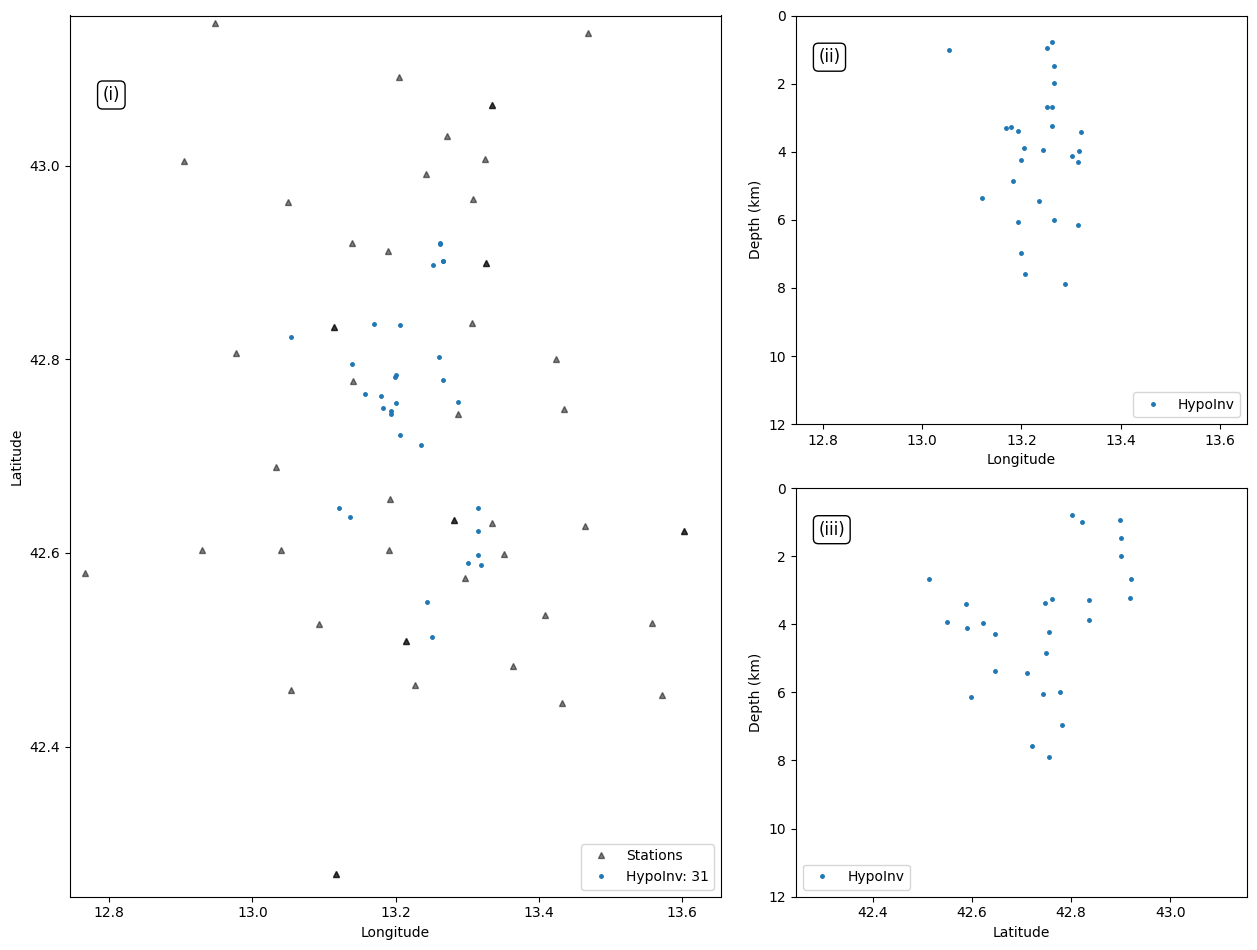

In [13]:
marker_size=5
hyp_label="HypoInv"
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([2,2]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1,1])
fig.add_subplot(grd[:, 0])
plt.plot(stations["longitude"], stations["latitude"], 'k^', markersize=marker_size, alpha=0.5, label="Stations")
plt.plot(events_hpy["LON"], events_hpy["LAT"], '.',markersize=marker_size, alpha=1.0, rasterized=True, label=f"{hyp_label}: {len(events_hpy)}")

plt.gca().set_aspect(111/82)
plt.xlim(np.array(config["xlim_degree"])+np.array([-0.03,0.03]))
plt.ylim(np.array(config["ylim_degree"])+np.array([-0.03,0.03]))
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', markersize=10)
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top",
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[0, 1])
plt.plot(events_hpy["LON"], events_hpy["DEPTH"], '.', markersize=marker_size, alpha=1.0, rasterized=True,label=f"{hyp_label}")

plt.xlim(np.array(config["xlim_degree"])+np.array([-0.03,0.03]))
plt.ylim(bottom=0, top=12)
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, 31, '.', markersize=10)
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top",
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)


fig.add_subplot(grd[1, 1])
plt.plot(events_hpy["LAT"], events_hpy["DEPTH"], '.', markersize=marker_size, alpha=1.0, rasterized=True,label=f"{hyp_label}")

plt.xlim(np.array(config["ylim_degree"])+np.array([-0.03,0.03]))
plt.ylim(bottom=0, top=12)
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["ylim_degree"][0]-10, 31, '.', markersize=10)
plt.legend(loc="lower left")
plt.tight_layout()
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top",
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

plt.show()

### HypoDD 
Run with test data. 

Since the test dataset (10 min, ~30 events) is too sparse to run double difference reloation, we commented out the code here. The following code blocks convert the output from HypoInvese into HypoDD input format. 

When running HypoDD, you may need to change the .inp files. 

See HypoDD manual (https://github.com/fwaldhauser/HypoDD)

##### Write phase file from HypoInverese output

In [14]:
import datetime
import math
import sys
import os

def format_convert(phaseinput,phaseoutput):

    g = open(phaseoutput, 'w')
    nn = 100000

    with open(phaseinput, "r") as f:
        for line in f:
            if (len(line) == 180):
                iok = 0
                RMS = float(line[48:52]) / 100
                gap = int(line[42:45])
                dep = float(line[31:36])/100
                EZ = float(line[89:93])/100
                EH = float(line[85:89])/100

                nn = nn + 1
                year = int(line[0:4])
                mon = int(line[4:6])
                day = int(line[6:8])
                hour = int(line[8:10])
                min = int(line[10:12])
                sec = int(line[12:16])/100

                if line[18] == ' ': #N
                    lat = (float(line[16:18]) + float(line[19:23]) / 6000)
                else:
                    lat = float(line[16:18]) + float(line[19:23])/6000 * (-1)

                if line[26] == 'E':
                    lon = (float(line[23:26]) + float(line[27:31]) / 6000)
                else:
                    lon = (float(line[23:26]) + float(line[27:31]) / 6000) * (-1)

                mag = float(line[123:126])/100
                g.write(
                    '# {:4d} {:2d} {:2d} {:2d} {:2d} {:5.2f}  {:7.4f} {:9.4f}   {:5.2f} {:5.2f} {:5.2f} {:5.2f} {:5.2f} {:9d} E\n'.format(
                        year, mon, day, hour, min, sec, lat, lon, dep, mag, EH, EZ, RMS, nn))
                iok = 1
            else:
                if (iok == 1 and len(line) == 121):
                    station = line[0:5]
                    net = line[5:7]
                    chn = line[9:11]
                    year1 = int(line[17:21])
                    mon1 = int(line[21:23])
                    day1 = int(line[23:25])
                    hour1 = int(line[25:27])
                    min1 = int(line[27:29])

                    if year1 == year and mon1 == mon and day1 == day and hour1 == hour and min1 == min:
                        sec_p =sec
                        if line[13:15] == ' P' or line[13:15] == 'IP':
                            P_residual = abs(int(line[34:38]) / 100)
                            sec_p = int(line[29:34]) / 100
                            ppick = sec_p-sec
                            
                            g.write('{:<2s}{:<5s}    {:8.3f}   1.000   P {:<2s} \n'.format(net, station, ppick,chn))

                        if line[46:48] == ' S' or line[46:48] == 'ES':
                            S_residual = abs(int(line[50:54]) / 100)
                            sec_s = int(line[41:46]) / 100
                            spick = sec_s-sec
                            
                            g.write('{:<2s}{:<5s}    {:8.3f}   1.000   S {:<2s} \n'.format(net, station, spick,chn))
    f.close()
    g.close()

%cd /app
input_file = './hypoInv/hypoOut.arc'
Path('./hypodd/results_hypodd').mkdir(parents=True, exist_ok=True)
output_file = './hypodd/results_hypodd/hypoDD.pha'
format_convert(input_file, output_file)
print('phase file:', output_file)
%cp stations_hypoDD.dat ./hypodd/results_hypodd/.


/app
phase file: ./hypodd/results_hypodd/hypoDD.pha


##### Convert phase file to time difference file (dt.ct)

In [15]:
## Skipped for the 10 min test dataset in the tutorial 
# %cd /app/hypodd/results_hypodd
# %pwd
# !ph2dt ph2dt.inp

##### Run double-difference relocation

In [16]:
## Skipped for the 10 min test dataset in the tutorial 
# !hypoDD hypoDD.inp

##### Read HypoDD output

In [17]:
## Skipped for the 10 min test dataset in the tutorial 
# events_hypodd = pd.read_csv('./hypoDD.reloc',header=None, sep="\s+",names=['ID', 'LAT', 'LON', 'DEPTH', 'X', 'Y', 'Z', 'EX', 'EY', 'EZ', 'YR', 'MO', 'DY', 'HR', 'MI', 'SC', 'MAG', 'NCCP', 'NCCS', 'NCTP', 'NCTS', 'RCC', 'RCT', 'CID'])
# events_hypodd

##### Plot event locations

In [18]:
## Skipped for the 10 min test dataset in the tutorial 


# marker_size=5
# hyp_label="HypoInv"
# hypodd_label='HypoDD'
# fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([2,2]))
# box = dict(boxstyle='round', facecolor='white', alpha=1)
# text_loc = [0.05, 0.92]
# grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1,1])
# fig.add_subplot(grd[:, 0])
# plt.plot(stations["longitude"], stations["latitude"], 'k^', markersize=marker_size, alpha=0.5, label="Stations")
# plt.plot(events_hpy["LON"], events_hpy["LAT"], '.',markersize=marker_size, alpha=1.0, rasterized=True, label=f"{hyp_label}: {len(events_hpy)}")
# plt.plot(events_hypodd["LON"], events_hypodd["LAT"], '.',markersize=marker_size, alpha=1.0, rasterized=True, label=f"{hypodd_label}: {len(events_hypodd)}")


# plt.gca().set_aspect(111/82)
# plt.xlim(np.array(config["xlim_degree"])+np.array([-0.03,0.03]))
# plt.ylim(np.array(config["ylim_degree"])+np.array([-0.03,0.03]))
# plt.ylabel("Latitude")
# plt.xlabel("Longitude")
# plt.gca().set_prop_cycle(None)
# plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', markersize=10)
# plt.legend(loc="lower right")
# plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top",
#          transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

# fig.add_subplot(grd[0, 1])
# plt.plot(events_hpy["LON"], events_hpy["DEPTH"], '.', markersize=marker_size, alpha=1.0, rasterized=True,label=f"{hyp_label}")
# plt.plot(events_hypodd["LON"], events_hypodd["DEPTH"], '.', markersize=marker_size, alpha=1.0, rasterized=True,label=f"{hypodd_label}")

# plt.xlim(np.array(config["xlim_degree"])+np.array([-0.03,0.03]))
# plt.ylim(bottom=0, top=12)
# plt.gca().invert_yaxis()
# plt.xlabel("Longitude")
# plt.ylabel("Depth (km)")
# plt.gca().set_prop_cycle(None)
# plt.plot(config["xlim_degree"][0]-10, 31, '.', markersize=10)
# plt.legend(loc="lower right")
# plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top",
#          transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)


# fig.add_subplot(grd[1, 1])
# plt.plot(events_hpy["LAT"], events_hpy["DEPTH"], '.', markersize=marker_size, alpha=1.0, rasterized=True,label=f"{hyp_label}")
# plt.plot(events_hypodd["LAT"], events_hypodd["DEPTH"], '.', markersize=marker_size, alpha=1.0, rasterized=True,label=f"{hypodd_label}")

# plt.xlim(np.array(config["ylim_degree"])+np.array([-0.03,0.03]))
# plt.ylim(bottom=0, top=12)
# plt.gca().invert_yaxis()
# plt.xlabel("Latitude")
# plt.ylabel("Depth (km)")
# plt.gca().set_prop_cycle(None)
# plt.plot(config["ylim_degree"][0]-10, 31, '.', markersize=10)
# plt.legend(loc="lower left")
# plt.tight_layout()
# plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top",
#          transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

# plt.show()

### HypoDD (example)
We provide an example of one day (2016/10/18) data in the Amatrice, Italy sequence to test run HypoDD. The input phase file is generated using the same workflow introduced in this tutorial notebook.

##### Convert phase file to time difference file (dt.ct)

In [19]:
%cd /app/hypodd/hypodd_example
%pwd
!ph2dt ph2dt.inp

/app/hypodd/hypodd_example
starting ph2dt (v2.1b - 08/2012)...     Sun Apr 28 20:57:35 2024 

reading data ...
 > stations =           67
 > events total =         2635
 > events selected =         2635
 > phases =        82478
forming dtimes...
 > stations selected =           52
 > P-phase pairs total =       933760
 > S-phase pairs total =      1116260
 > outliers =       112326  (           5 %)
 > phases at stations not in station list =       707399
 > phases at distances larger than MAXDIST =            0
 > P-phase pairs selected =       382488  (          40 %)
 > S-phase pairs selected =       484074  (          43 %)
 > weakly linked events =          161  (           6 %)
 > linked event pairs =        54670
 > average links per pair =           15
 > average offset (km) betw. linked events =    2.41818690    
 > average offset (km) betw. strongly linked events =    2.89636850    
 > maximum offset (km) betw. strongly linked events =    11.9986162    

Done.  Sun Apr 28 20:

##### Run double-difference relocation

In [20]:
!hypoDD hypoDD.inp

starting hypoDD (v2.1beta - 06/15/2016)...   Sun Apr 28 20:57:38 2024 
Input parameters: hypoDD.inp (hypoDD2.0 format)
INPUT FILES:
 cross dtime data:  
 catalog dtime data: dt.ct
 events: event.sel
 stations: station.sel
OUTPUT FILES:
 initial locations: hypoDD.loc
 relocated events: hypoDD.reloc
 event pair residuals: hypoDD.res
 station residuals: hypoDD.sta
 source parameters: hypoDD.src
Use local layered 1D model.
Relocate cluster number    1
Relocate all events
Remove air quakes.
Reading data ...   Sun Apr 28 20:57:38 2024 
# events =  2635
# stations < maxdist =     52
# stations w/ neg. elevation (set to 0) =    0
# catalog P dtimes =  380059
# catalog S dtimes =  481342
# dtimes total =   861401
# events after dtime match =       2263
# stations =     47
clustering ...  
Clustered events:  1972
Isolated events:   291
# clusters:    4
Cluster   1:  1965 events
Cluster   2:     3 events
Cluster   3:     2 events
Cluster   4:     2 events

RELOCATION OF CLUSTER: 1     Sun Apr 28 

##### Read HypoDD output

In [21]:
events_hypodd = pd.read_csv('./hypoDD.reloc',header=None, sep="\s+",names=['ID', 'LAT', 'LON', 'DEPTH', 'X', 'Y', 'Z', 'EX', 'EY', 'EZ', 'YR', 'MO', 'DY', 'HR', 'MI', 'SC', 'MAG', 'NCCP', 'NCCS', 'NCTP', 'NCTS', 'RCC', 'RCT', 'CID'])
events_hypodd

,ID,LAT,LON,DEPTH,X,Y,Z,EX,EY,EZ,...,MI,SC,MAG,NCCP,NCCS,NCTP,NCTS,RCC,RCT,CID
0,113825,42.900224,13.256211,3.249,4497.0,12620.9,-1405.3,143.2,193.8,333.9,...,0,12.80,0.0,0,0,368,417,-9.0,0.168,1
1,113827,42.742236,13.194716,5.578,-530.7,-4929.7,923.8,159.1,174.6,172.3,...,0,55.20,0.0,0,0,393,464,-9.0,0.138,1
2,113829,42.836812,13.162251,5.476,-3185.7,5576.6,821.7,130.2,104.5,167.8,...,1,43.52,0.0,0,0,589,733,-9.0,0.132,1
3,113830,42.710832,13.228359,5.398,2223.5,-8418.4,744.1,222.3,183.7,345.1,...,2,9.29,0.0,0,0,231,48,-9.0,0.185,1
4,113831,42.756763,13.179973,2.664,-1737.3,-3316.0,-1990.1,150.9,194.3,266.2,...,2,41.27,0.0,0,0,482,556,-9.0,0.120,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808,116488,42.800183,13.190090,5.220,-909.0,1507.5,565.6,126.7,131.7,225.4,...,55,34.78,0.0,0,0,110,239,-9.0,0.119,1
1809,116489,42.661751,13.218293,7.283,1400.0,-13870.7,2628.9,116.7,143.2,242.2,...,56,6.20,0.0,0,0,314,426,-9.0,0.108,1
1810,116492,42.817647,13.181880,2.591,-1580.5,3447.6,-2063.3,135.1,106.2,202.4,...,57,33.16,0.0,0,0,690,775,-9.0,0.151,1
1811,116494,42.869812,13.176278,1.597,-2037.9,9242.5,-3057.7,149.5,122.2,187.0,...,59,12.40,0.0,0,0,381,536,-9.0,0.161,1


##### Plot event locations of the 1-day example

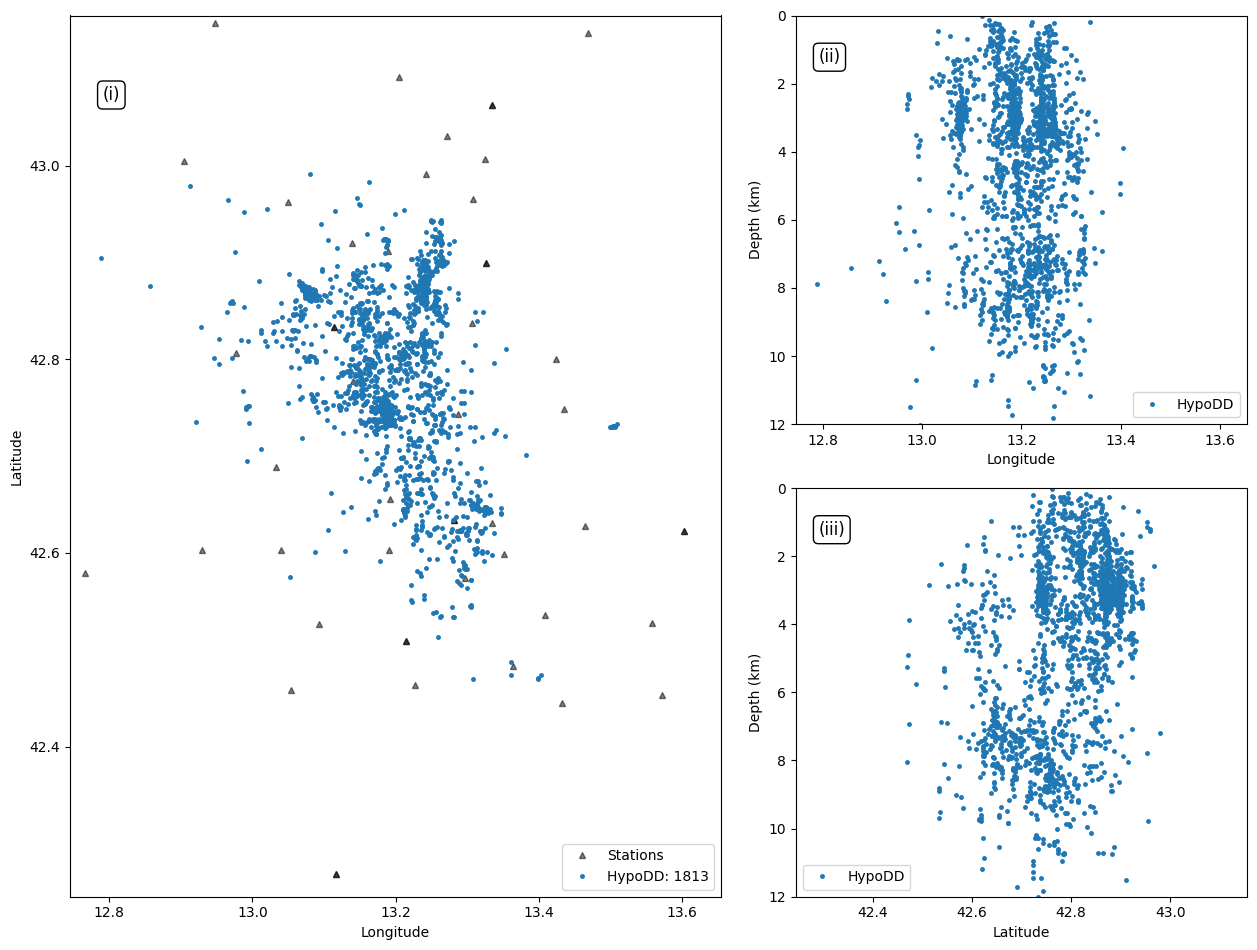

In [22]:
marker_size=5
hyp_label="HypoInv"
hypodd_label='HypoDD'
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([2,2]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1,1])
fig.add_subplot(grd[:, 0])
plt.plot(stations["longitude"], stations["latitude"], 'k^', markersize=marker_size, alpha=0.5, label="Stations")
# plt.plot(events_hpy["LON"], events_hpy["LAT"], '.',markersize=marker_size, alpha=1.0, rasterized=True, label=f"{hyp_label}: {len(events_hpy)}")
plt.plot(events_hypodd["LON"], events_hypodd["LAT"], '.',markersize=marker_size, alpha=1.0, rasterized=True, label=f"{hypodd_label}: {len(events_hypodd)}")


plt.gca().set_aspect(111/82)
plt.xlim(np.array(config["xlim_degree"])+np.array([-0.03,0.03]))
plt.ylim(np.array(config["ylim_degree"])+np.array([-0.03,0.03]))
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', markersize=10)
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top",
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[0, 1])
# plt.plot(events_hpy["LON"], events_hpy["DEPTH"], '.', markersize=marker_size, alpha=1.0, rasterized=True,label=f"{hyp_label}")
plt.plot(events_hypodd["LON"], events_hypodd["DEPTH"], '.', markersize=marker_size, alpha=1.0, rasterized=True,label=f"{hypodd_label}")

plt.xlim(np.array(config["xlim_degree"])+np.array([-0.03,0.03]))
plt.ylim(bottom=0, top=12)
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, 31, '.', markersize=10)
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top",
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)


fig.add_subplot(grd[1, 1])
# plt.plot(events_hpy["LAT"], events_hpy["DEPTH"], '.', markersize=marker_size, alpha=1.0, rasterized=True,label=f"{hyp_label}")
plt.plot(events_hypodd["LAT"], events_hypodd["DEPTH"], '.', markersize=marker_size, alpha=1.0, rasterized=True,label=f"{hypodd_label}")

plt.xlim(np.array(config["ylim_degree"])+np.array([-0.03,0.03]))
plt.ylim(bottom=0, top=12)
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["ylim_degree"][0]-10, 31, '.', markersize=10)
plt.legend(loc="lower left")
plt.tight_layout()
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top",
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

plt.show()